W kodzie przedstawiono wynik nieintuicyjnego zeregowania istotności zmiennych zależnych wg metodyFeature_importance w pakiecie sklearn dla modeli uczenia zespołowego. Ćwiczenie wykonane na przykładzie przypadkowego zbioru danych odnośnie leadów x-sellowania kart kredytowych. Kod pomija wszelkie dodatkowe sprawdzenia poboczne jak np. nulle w kolumnie czy skośność rozkładów.  

In [3]:
#ładowanie potrzebnych w kodzie bibliotek 
import zipfile
import pandas as pd
import os
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import opendatasets as od # biblioteka potrzebna do pobrania danych z kaggle.com,  pip install opendatabases
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)


In [5]:
# import danych, pochodzenie https://www.kaggle.com/datasets/shelvigarg/credit-card-buyers/download
# następnie pobieramy dane: w tym celu należy utworzyć konto na Kaggle. następnie w parametrach funkcji podajemu
# nazwę urzytkownika, klucz API - można go pobrać klikając w My account i następnie  Create New API Token
# zostanie wygenerowany zestaw username + key, który wklejamy do funkcji 
#{"username":"yourUserName","key":"yourKaggleKey"}  <- tego nie pokazywać!!!!!
#{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}

od.download("https://www.kaggle.com/datasets/shelvigarg/credit-card-buyers/archive.zip")
#dane zostały załadowane do folderu ".\credit-card-buyers" o czym dowiadujemy się z ponizszego komunikatu

Skipping, found downloaded files in ".\credit-card-buyers" (use force=True to force download)


In [6]:
#sprawdzenie z jakimi zbiorami mamy do czynienia: ze względu na nadzorowany rodzaj ćwiczenia, analizę przeprowadzę na zbiorze treningowym zawierającym flagę
data_dir = '.\credit-card-buyers'
os.listdir(data_dir)

['test data credit card.csv', 'train data credit card.csv']

In [ ]:
# zappisanie danych na dysku 
copy_to = "E:/page ds/pages/szeregowanie mocy zmiennych modelu drzewa/redit_card.csv" 
credit_cards_data = pd.read_csv("credit-card-buyers/train data credit card.csv")
credit_cards_data.to_csv(copy_to, index = False) 

In [40]:
#odczytanie danych z dysku aby nie pobierać ich prosto ze strony
copy_to = "E:/page ds/pages/szeregowanie mocy zmiennych modelu drzewa/redit_card.csv" 
credit_cards_data = pd.read_csv(copy_to)


In [8]:
display(credit_cards_data)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...,...
245720,BPAWWXZN,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0
245721,HFNB7JY8,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245722,GEHAUCWT,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245723,GE7V8SAH,Female,28,RG273,Salaried,X1,31,No,407504,No,0


In [10]:
#rozkład zmiennej celu
credit_cards_data["Is_Lead"].value_counts()

0    187437
1     58288
Name: Is_Lead, dtype: int64

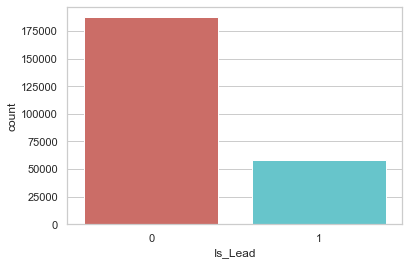

<Figure size 432x288 with 0 Axes>

In [13]:
sns.countplot(x='Is_Lead', data=credit_cards_data, palette='hls')
plt.show()
plt.savefig('count_plot')

In [15]:
credit_cards_data.groupby('Is_Lead').mean()

,Age,Vintage,Avg_Account_Balance
Is_Lead,,,
0,41.947662,41.913923,1.103018e+06
1,49.993944,63.183074,1.210034e+06


<AxesSubplot:xlabel='Is_Lead', ylabel='count'>

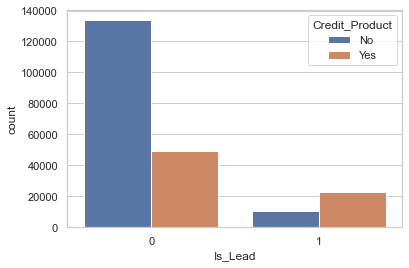

In [16]:
sns.countplot(data = credit_cards_data, x ='Is_Lead', hue = 'Credit_Product' )


In [17]:
credit_cards_data.groupby('Credit_Product')['Is_Lead'].value_counts().unstack()

Is_Lead,0,1
Credit_Product,,
No,133734,10623
Yes,49353,22690


In [18]:
#pułapka: w kolumnie mamy nulle 
credit_cards_data['Credit_Product'].isna().sum()

29325

In [41]:
#wypełnienie nulli wartoscią braku informacji 
credit_cards_data['Credit_Product'] = credit_cards_data['Credit_Product'].fillna('NoInfo')

In [20]:
credit_cards_data.groupby('Credit_Product')['Is_Lead'].value_counts().unstack()

Is_Lead,0,1
Credit_Product,,
No,133734,10623
NoInfo,4350,24975
Yes,49353,22690


In [42]:
#sprawdzenie czy są jeszcze inne kolumny z wartością null
credit_cards_data.isnull().sum()

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

In [43]:
# rozkład dla regionu
data1 = [] 
cnt = len(credit_cards_data['Region_Code'])

for val in list(credit_cards_data['Region_Code'].unique()):
    cnt_tmp = len(credit_cards_data[credit_cards_data['Region_Code']==val])
    data1.append([val, cnt_tmp, cnt_tmp/cnt])

df = pd.DataFrame(data1, columns=['value', 'count', 'percentage'])
df

,value,count,percentage
0,RG268,35934,0.146237
1,RG277,12826,0.052197
2,RG270,7720,0.031417
3,RG282,5829,0.023722
4,RG261,7633,0.031063
5,RG265,1546,0.006292
6,RG283,29416,0.119711
7,RG254,26840,0.109228
8,RG269,7863,0.031999
9,RG257,6101,0.024829


In [24]:
print(credit_cards_data['Occupation'].value_counts())
print(len(credit_cards_data['Occupation'].unique()))

Self_Employed    100886
Salaried          71999
Other             70173
Entrepreneur       2667
Name: Occupation, dtype: int64
4


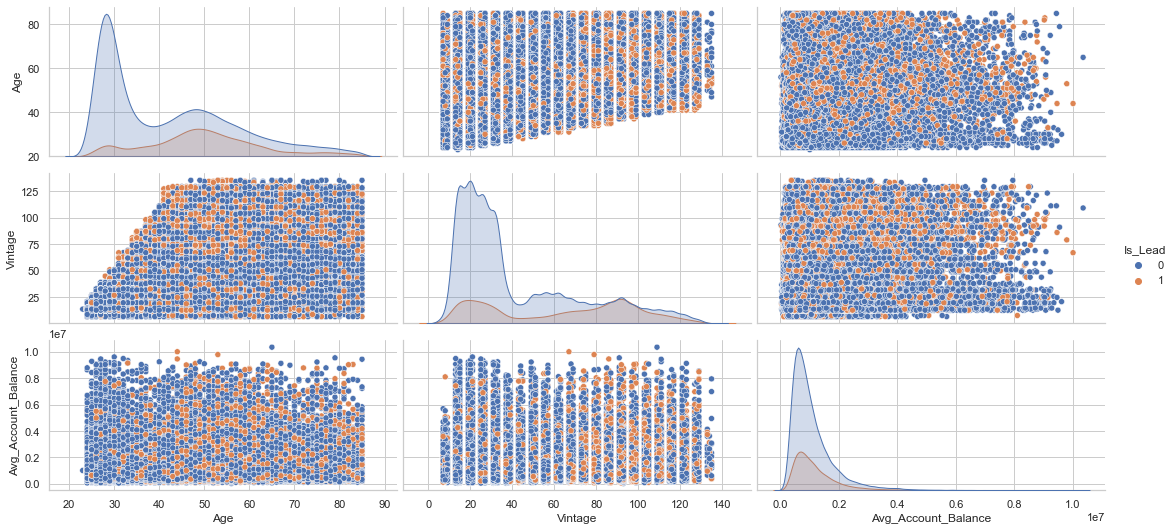

In [26]:
sns.pairplot(credit_cards_data.loc[:, ['Age', 'Vintage', 'Avg_Account_Balance','Is_Lead']], hue = 'Is_Lead', aspect = 21/10)

In [44]:
# dodanie zmiennych kategorycznych, robię to w pętli ale można skorzystać równiez z metody OneHotEncoding
cat_vars=['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']
for var in cat_vars:
    cat_list = pd.get_dummies(credit_cards_data[var], prefix=var)
    data1 = credit_cards_data.join(cat_list)
    credit_cards_data = data1


data_vars = credit_cards_data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=credit_cards_data[to_keep]
data_final.columns.values

array(['ID', 'Age', 'Vintage', 'Avg_Account_Balance', 'Is_Lead',
       'Gender_Female', 'Gender_Male', 'Region_Code_RG250',
       'Region_Code_RG251', 'Region_Code_RG252', 'Region_Code_RG253',
       'Region_Code_RG254', 'Region_Code_RG255', 'Region_Code_RG256',
       'Region_Code_RG257', 'Region_Code_RG258', 'Region_Code_RG259',
       'Region_Code_RG260', 'Region_Code_RG261', 'Region_Code_RG262',
       'Region_Code_RG263', 'Region_Code_RG264', 'Region_Code_RG265',
       'Region_Code_RG266', 'Region_Code_RG267', 'Region_Code_RG268',
       'Region_Code_RG269', 'Region_Code_RG270', 'Region_Code_RG271',
       'Region_Code_RG272', 'Region_Code_RG273', 'Region_Code_RG274',
       'Region_Code_RG275', 'Region_Code_RG276', 'Region_Code_RG277',
       'Region_Code_RG278', 'Region_Code_RG279', 'Region_Code_RG280',
       'Region_Code_RG281', 'Region_Code_RG282', 'Region_Code_RG283',
       'Region_Code_RG284', 'Occupation_Entrepreneur', 'Occupation_Other',
       'Occupation_Salaried', 

In [48]:
# jak można było zauważyć na poprzednich analizach, zbiór jest mocno niezbalansowany względem zmiennej Is_Lead
# balansuję zmienną celu
from imblearn.over_sampling import SMOTE
from sklearn.base import _ClassNamePrefixFeaturesOutMixin

#data_final = data_final.pop('ID')
data_final = data_final.drop('ID', axis=1)

X = data_final.loc[:, data_final.columns != 'Is_Lead']
y = data_final.loc[:, data_final.columns == 'Is_Lead']

os = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
columns = X_train.columns


os_data_X, os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Is_Lead'])


In [49]:
# sprawdzenie czy dane zostały zbalansowane
print("\033[1m Length of oversampled data is:",len(os_data_X))
print("\033[1m Number of default in oversampled data is:",len(os_data_y[os_data_y['Is_Lead']==1]))
print("\033[1m Number of no-default in oversampled data is:",len(os_data_y[os_data_y['Is_Lead']==0]))
print("\033[1m Proportion of default data in oversampled data is:",len(os_data_y[os_data_y['Is_Lead']==1])/len(os_data_X))
print("\033[1m Proportion of no-default data in oversampled data is:",len(os_data_y[os_data_y['Is_Lead']==0])/len(os_data_X))

 Length of oversampled data is: 251140
 Number of default in oversampled data is: 125570
 Number of no-default in oversampled data is: 125570
 Proportion of default data in oversampled data is: 0.5
 Proportion of no-default data in oversampled data is: 0.5


In [50]:
# wybór najlepszych charakterystyk wg drzewa decyzyjnego aby ograniczyć zmienne na wykresie

data_final_vars=data_final.columns.values.tolist()
y=['Is_Lead']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
rfe = RFE(model, n_features_to_select = 24,step=1)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True False False False False  True False False
 False False False False False False False False False False False  True
  True False False False False False False False  True False False  True
 False False  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True]
[ 1  1  1  1  1 21  3 15 18  1 19 25  7 24 20 17  2 26 10 22 27 28 30  1
  1  4 29  5  9 11 16 13  1 23 12  1  6  8  1  1  1  1  1  1  1  1  1 14
  1  1  1  1  1]


In [51]:
X = os_data_X
y = os_data_y
data_X2 = pd.DataFrame({
 'Feature': X.columns,
 'Importance': rfe.ranking_},)
data_X2.sort_values(by=['Importance'])

,Feature,Importance
0,Age,1
51,Is_Active_No,1
32,Region_Code_RG277,1
35,Region_Code_RG280,1
38,Region_Code_RG283,1
39,Region_Code_RG284,1
40,Occupation_Entrepreneur,1
41,Occupation_Other,1
42,Occupation_Salaried,1
43,Occupation_Self_Employed,1


In [52]:
# i ostateczne ograniczenie do najistotniejszych charakterystyk
cols=[]
for i in range (0, len(data_X2['Importance'])):
     if data_X2['Importance'][i] == 1:
            cols.append(data_X2['Feature'][i])
print(cols)
print(len(cols))

['Age', 'Vintage', 'Avg_Account_Balance', 'Gender_Female', 'Gender_Male', 'Region_Code_RG254', 'Region_Code_RG268', 'Region_Code_RG269', 'Region_Code_RG277', 'Region_Code_RG280', 'Region_Code_RG283', 'Region_Code_RG284', 'Occupation_Entrepreneur', 'Occupation_Other', 'Occupation_Salaried', 'Occupation_Self_Employed', 'Channel_Code_X1', 'Channel_Code_X2', 'Channel_Code_X3', 'Credit_Product_No', 'Credit_Product_NoInfo', 'Credit_Product_Yes', 'Is_Active_No', 'Is_Active_Yes']
24


In [64]:
X = X[cols]
y = y['Is_Lead']

Mamy już przygotowane dane, teraz budujemy modele i sprawdzamy jak się klasyfikują zmienne losowe ciągłe oraz dyskretne

In [89]:
# funkcja do rysowania ważności zmiennych
import matplotlib.patches as mpatches
def plot_feature_importances_loans(model, set_):
    loans_features_ = [x for i,x in enumerate(set_.columns) if i!=len(set_.columns)]
    plt.figure(figsize=(12,6))
    n_features = len(set_.columns)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), loans_features_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    rect=mpatches.Rectangle((0,len(set_.columns)-2.6),max(clf.feature_importances_),2.2, 
                        fill = False,
                        color = "purple",
                        linewidth = 2)
    plt.gca().add_patch(rect)


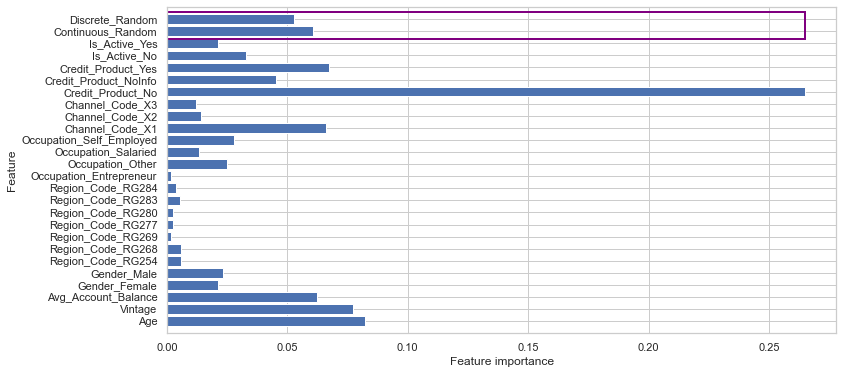

In [91]:
from numpy import random
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#dodanie zmiennej losowej, dyskretnej jak i ciągłej
for zbior in [X_train, X_test]:
    zbior['Continuous_Random'] = [random.uniform(100,200) for _ in range(len(zbior))]
    zbior['Discrete_Random'] = [random.randint(100,200) for _ in range(len(zbior))]

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
plot_feature_importances_loans(clf, X_train)
plt.savefig('E:/page ds/pages/szeregowanie mocy zmiennych modelu drzewa/feature_importance_RandomForest.png')

Zmienne losowe mają bardzo wysoką istotność w modelu lasu losowego!!!
Poniżej sprawdzenie tematu dla innych metod zespołowych

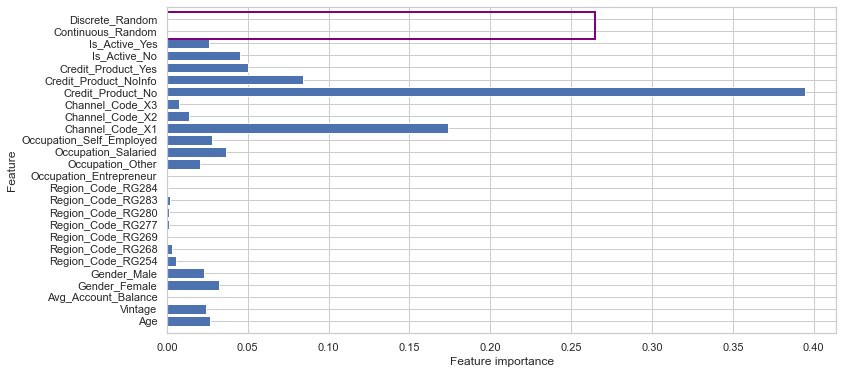

In [109]:
#inne modele zespołowe: 
from sklearn.ensemble import ExtraTreesClassifier
rfc_model = ExtraTreesClassifier(n_estimators=400, random_state=0, max_depth= 5, min_samples_leaf=3, max_features='sqrt') 
rfc_model.fit(X_train,y_train) 
plot_feature_importances_loans(rfc_model, X_train)
plt.savefig('E:/page ds/pages/szeregowanie mocy zmiennych modelu drzewa/feature_importance_ExtraTrees.png')
# odporny na zmienne losowe

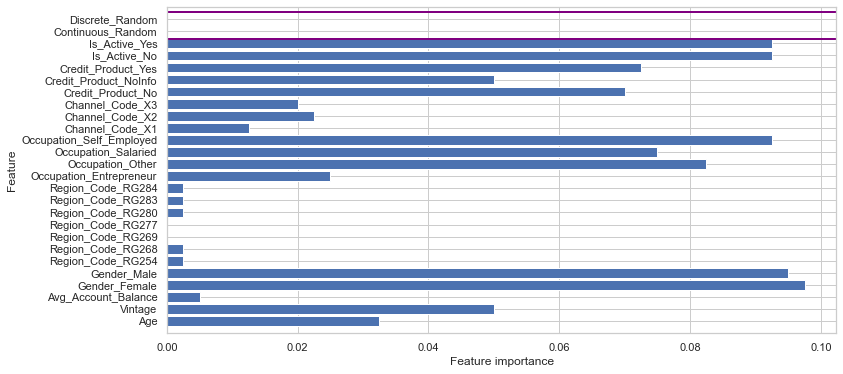

In [111]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier(n_estimators=400, learning_rate=0.65) 
ada_model.fit(X_train,y_train) 
plot_feature_importances_loans(ada_model, X_train)
plt.savefig('E:/page ds/pages/szeregowanie mocy zmiennych modelu drzewa/feature_importance_AdaBoost.png')
# również odporny na zmienne losowe

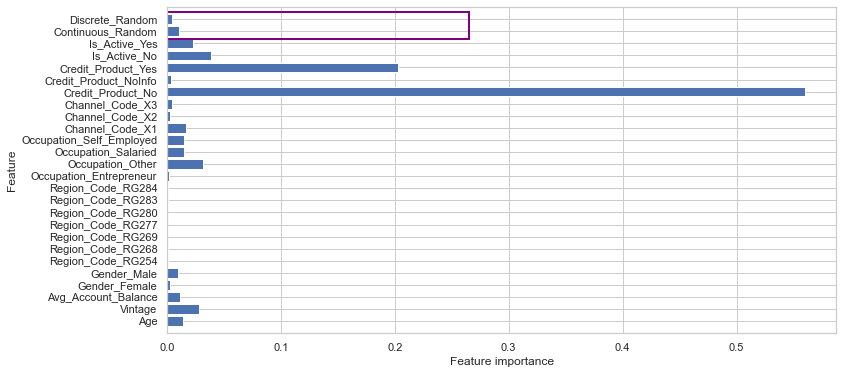

In [113]:
from sklearn.ensemble import GradientBoostingClassifier
xgb_model = GradientBoostingClassifier(n_estimators=400, max_depth=6) 
xgb_model.fit(X_train,y_train) 
plot_feature_importances_loans(xgb_model, X_train)
plt.savefig('E:/page ds/pages/szeregowanie mocy zmiennych modelu drzewa/feature_importance_xgb_model.png')
#metoda XGBoost również wskazuje nieznaczną istotność zmiennych losowych!! Nie jest to na szczęście taka sama istotność jak w przypadku lasów losowych

W celu upewnienia się czy zmienna jest istotna, korzystamy z metody permutation_importance  

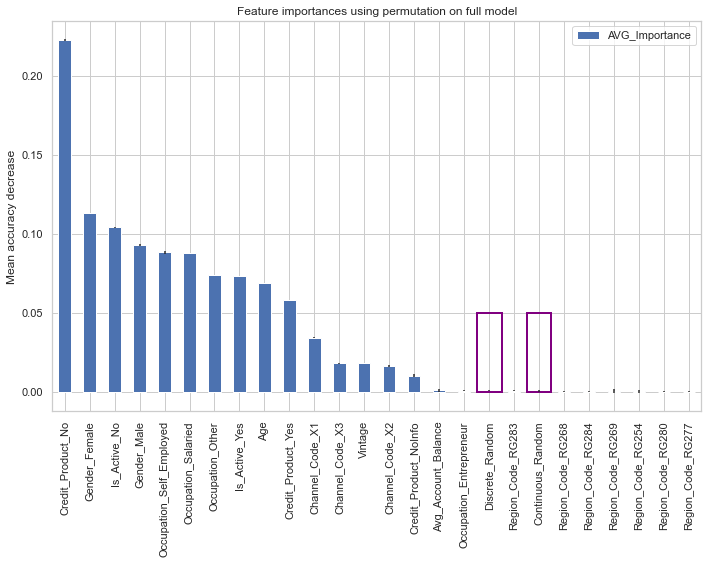

In [122]:
from sklearn.inspection import permutation_importance

r = permutation_importance(clf, X_test, y_test,
                           n_repeats=10,
                           random_state=0)
perm = pd.DataFrame(columns=['AVG_Importance'], index=[i for i in X_train.columns])
perm['AVG_Importance'] = r.importances_mean
perm.sort_values(by=['AVG_Importance'], inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,8))
perm.plot.bar(yerr=r.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
rect=mpatches.Rectangle((16.5,0),1,0.05, 
                        fill = False,
                        color = "purple",
                        linewidth = 2)
rect2=mpatches.Rectangle((18.5,0),1,0.05, 
                        fill = False,
                        color = "purple",
                        linewidth = 2)
#plt.gca().add_patch(rect)
plt.gca().add_patch(rect)
plt.gca().add_patch(rect2)
plt.show()
plt.savefig('E:/page ds/pages/szeregowanie mocy zmiennych modelu drzewa/permutation_RandForest.png')


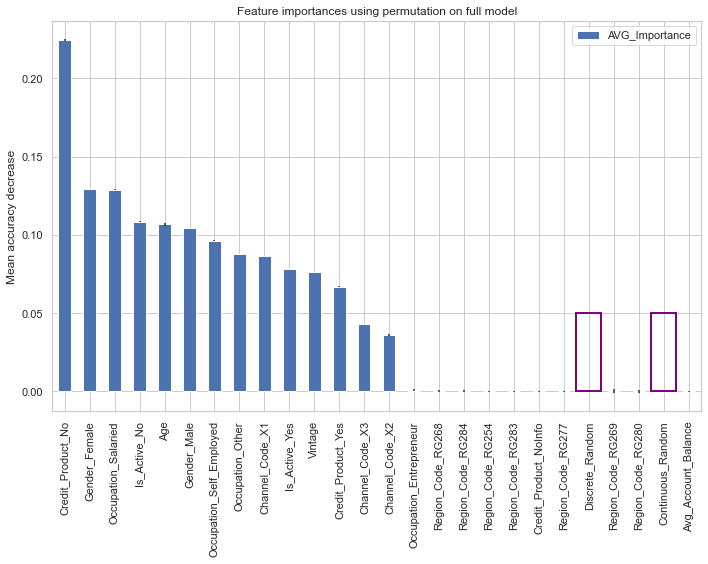

In [124]:
r2 = permutation_importance(xgb_model, X_test, y_test,
                           n_repeats=10,
                           random_state=0)
perm = pd.DataFrame(columns=['AVG_Importance'], index=[i for i in X_train.columns])
perm['AVG_Importance'] = r2.importances_mean
perm.sort_values(by=['AVG_Importance'], inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,8))
perm.plot.bar(yerr=r.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
rect=mpatches.Rectangle((20.5,0),1,0.05, 
                        fill = False,
                        color = "purple",
                        linewidth = 2)
rect2=mpatches.Rectangle((23.5,0),1,0.05, 
                        fill = False,
                        color = "purple",
                        linewidth = 2)
#plt.gca().add_patch(rect)
plt.gca().add_patch(rect)
plt.gca().add_patch(rect2)
plt.show()
plt.savefig('E:/page ds/pages/szeregowanie mocy zmiennych modelu drzewa/permutation_xgboost.png')